Task: Epipolar Geometry
Write a script/function, that visualizes correspondences and epipolar geometry between pair of images. Images, correspondences, and fundamentral matrix F is here.

The set of correspondences is produce by an automatic wide-baseline stereo matching tool, it contains both correct correspondences and mismatches. These must be separated, according to consistency with epipolar constraint:

for each corresponding pair  i
  of points, compute symmetric epipolar distance  di=0.5d21,i+d22,i−−−−−−−−√
  where  d1,i
  is euclidean (!) distance of a point  u1,i
  to the corresponding epipolar line  l1,i=FTu2,i
  in the first image, and  d2,i
  is euclidean distance of a point  u2,i
  to the corresponding epipolar line  l2,i=Fu1,i
  in the second image.
choose appropriate threshold, e.g.  θ=1
  px and separate correspondences to inliers ( di≤θ
 ) and outliers ( di>θ
 ).
Show the inliers (red) and outliers (black) as a needle map over one image. (A 'needle' is line joining coordinates of corresponing point in both image, but drawn to a single image.) Consistent motion should be visible in the inliers.
Select 20 (eg. random) correspondences from inliers, and draw to both images the points and the corresponding epipolar lines, in different but corresponding colours.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


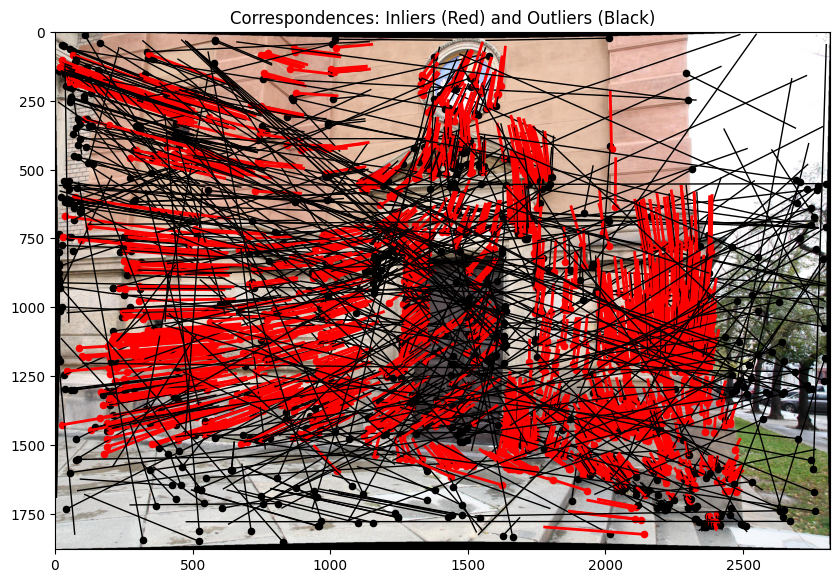

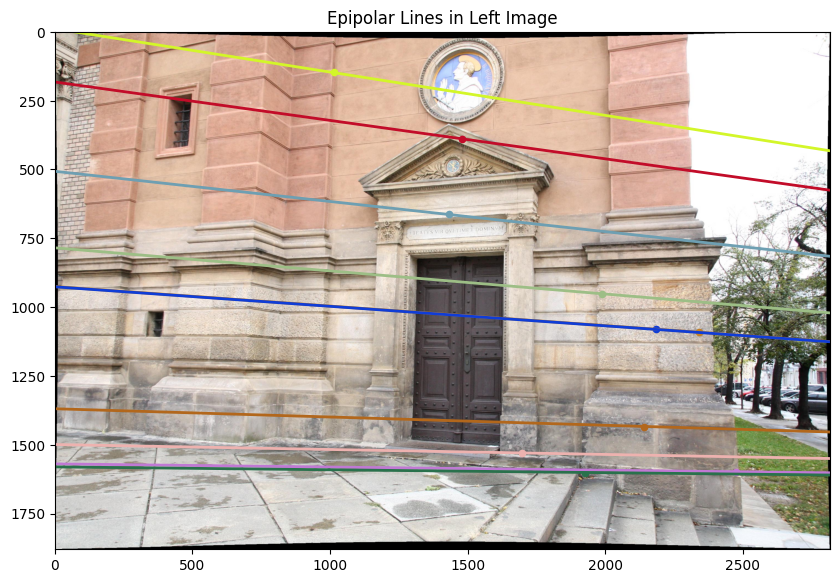

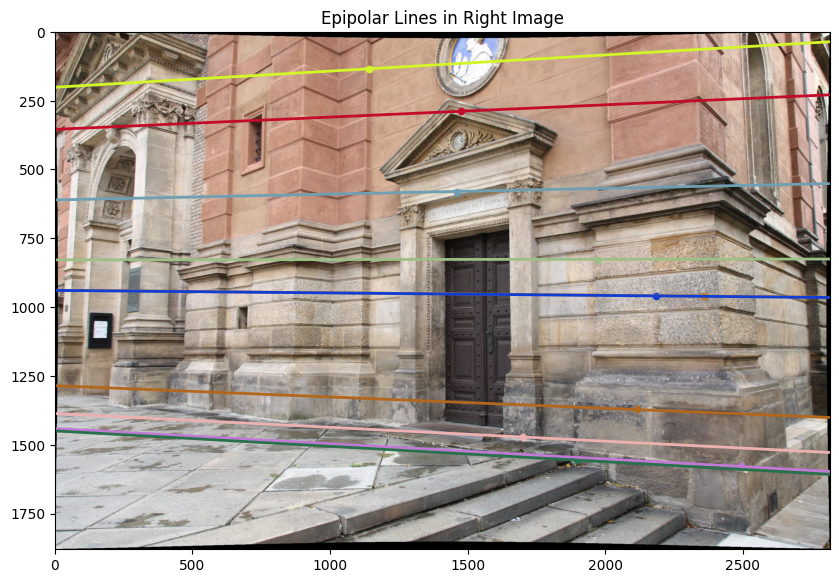

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Constants
K = np.array([[2080, 0, 1421],
              [0, 2080, 957],
              [0, 0, 1]])  # Calibration matrix

# Helper Functions
def compute_epipolar_lines(F, pts):
    """Compute epipolar lines for a set of points."""
    pts_h = np.hstack([pts, np.ones((pts.shape[0], 1))])  # Convert to homogeneous coordinates
    lines = (F @ pts_h.T).T  # Compute epipolar lines
    line_norms = np.linalg.norm(lines[:, :2], axis=1)  # Normalize by line coefficients
    lines /= line_norms[:, np.newaxis]  # Normalize the lines
    return lines

def draw_lines_and_points(img1, img2, pts1, pts2, F, n=10):
    """
    Visualize epipolar lines and points for corresponding points in two images.

    Args:
        img1: Left image.
        img2: Right image.
        pts1: Points in the left image (N x 2).
        pts2: Corresponding points in the right image (N x 2).
        F: Fundamental matrix (3 x 3).
        n: Number of correspondences to visualize.
    """
    # Ensuring visualize a subset of inliers
    n = min(len(pts1), n)
    indices = np.random.choice(range(len(pts1)), n, replace=False)
    pts1 = pts1[indices]
    pts2 = pts2[indices]

    # Compute epipolar lines
    lines1 = compute_epipolar_lines(F.T, pts2)  # Lines in the left image
    lines2 = compute_epipolar_lines(F, pts1)   # Lines in the right image

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    colors = [tuple(np.random.rand(3)) for _ in range(n)]  # Generate random colors

    # Left image visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    for pt1, line1, color in zip(pts1, lines1, colors):
        # Draw points
        plt.scatter(pt1[0], pt1[1], 20, color=color)
        # Draw epipolar line
        x = np.linspace(0, w1, 100)
        y = -(line1[0] * x + line1[2]) / (line1[1] + 1e-6)  # Avoiding division by zero
        plt.plot(x, y, color=color, linewidth=2)

    plt.title("Epipolar Lines in Left Image")
    plt.xlim([0, w1])
    plt.ylim([h1, 0])  # Invert y-axis for image coordinates
    plt.show()

    # Right image visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    for pt2, line2, color in zip(pts2, lines2, colors):
        # Draw points
        plt.scatter(pt2[0], pt2[1], 20, color=color)
        # Draw epipolar line
        x = np.linspace(0, w2, 100)
        y = -(line2[0] * x + line2[2]) / (line2[1] + 1e-6)  # Avoiding division by zero
        plt.plot(x, y, color=color, linewidth=2)

    plt.title("Epipolar Lines in Right Image")
    plt.xlim([0, w2])
    plt.ylim([h2, 0])  # Invert y-axis for image coordinates
    plt.show()

def visualize_correspondences_and_epipolar_geometry(img1_path, img2_path, keypoints_left_path, keypoints_right_path):
    # Load images
    img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
    img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)

    # Load points from the text files with whitespace as the default delimiter
    pts1 = np.loadtxt(keypoints_left_path)  # Points in the left image
    pts2 = np.loadtxt(keypoints_right_path)  # Points in the right image

    # Verify the shapes of the loaded arrays
    if pts1.shape[1] != 2 or pts2.shape[1] != 2:
        raise ValueError("Input files must have exactly two columns for x and y coordinates.")

    # Estimate the fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0)

    # Separate inliers and outliers
    inliers = mask.ravel() == 1
    outliers = mask.ravel() == 0

    in_pts1 = pts1[inliers]
    in_pts2 = pts2[inliers]

    # Visualize correspondences as a needle map (inliers in red, outliers in black)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    for (xA, yA), (xB, yB), is_inlier in zip(pts1, pts2, inliers):
        if is_inlier:
            plt.scatter(xA, yA, 20, 'r')  # Draw inlier points in red
            plt.plot([xA, xB], [yA, yB], 'r-', linewidth=2)  # Line connecting inliers
        else:
            plt.scatter(xA, yA, 20, 'black')  # Draw outlier points in black
            plt.plot([xA, xB], [yA, yB], 'k-', linewidth=1)  # Line connecting outliers

    plt.title("Correspondences: Inliers (Red) and Outliers (Black)")
    plt.show()

    # Visualize epipolar lines and points (using only inliers)
    draw_lines_and_points(img1, img2, in_pts1, in_pts2, F, n=10)

    # Visualize epipolar lines and points (showing only inliers)
    # draw_lines_and_points(img1, img2, in_pts1, in_pts2,
    #                       compute_epipolar_lines(F.T, in_pts2),
    #                       compute_epipolar_lines(F, in_pts1), n=20)

visualize_correspondences_and_epipolar_geometry(
    img1_path='/content/drive/MyDrive/3DCV/6_left.jpg',
    img2_path='/content/drive/MyDrive/3DCV/6_right.jpg',
    keypoints_left_path='/content/drive/MyDrive/3DCV/u_left.txt',
    keypoints_right_path='/content/drive/MyDrive/3DCV/u_right.txt'
)

